In [3]:
import numpy
from scipy.io import loadmat, whosmat

def read_mat_fig(filename):
    #whosmat('/Users/droryn/work/LVM/data/redux/PTC/b1ptcs.fig')
    output = []
    d = loadmat(filename, squeeze_me=True, struct_as_record=False)
    matfig = d['hgS_070000']
    childs = matfig.children
    ax = [c for c in childs if c.type == 'axes']
    #print(len(ax))
    # There should be 4 ax, one for each quadrant
    # order is BL, BR, TL, TR
    for ax1 in ax:
        # there's 2 or 3 graphs: [0]: low-count data, [1]: high count data, [2]: fit to low count
        for line in ax1.children:
            if line.type == 'graph2d.lineseries':
                x = line.properties.XData
                y = line.properties.YData
                output.append((x, y))
    o2 = []
    # merge low and high count data points
    if len(output) ==  12:
        for i in range(len(output))[::3]:
            # discard the fit data points, retain only the measurements
            x1, y1 = output[i]
            x2, y2 = output[i+1]
            o2.append((numpy.append(x1,x2), numpy.append(y1,y2)))
    else:
        assert(len(output)==8)
        for i in range(len(output))[::2]:
            x1, y1 = output[i]
            o2.append((x1,y1))
    return o2



In [10]:
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
%matplotlib inline

def fitf(x, p0, p1):
    return p0*x**p1

def fitlin(x, p0, p1):
    return p0*x + p1

def ptc_channel(c,s):

    quadrants = ['BL', 'BR', 'TL', 'TR']
    qindices = [(1,0), (1,2), (0,0), (0,2)]
    channel = c+s

    d = read_mat_fig('/Users/droryn/work/LVM/data/redux/PTC/'+channel+'ptcs.fig')
    fig, axs = plt.subplots(2,4)
    plt.tight_layout()
    for i in range(len(d)):
        quad = qindices[i]
        x,y = d[i]
        w = numpy.isfinite(y) & (x<62000) & (y<30000)
        if channel == 'b1':
            w = w & (x<40000) 
        x, y = x[w], y[w]
        s = numpy.argsort(x)
        x, y = x[s], y[s]
        # determine gain and ron^2 from low counts
        xlin = x<4000
        x0, y0 = x[xlin], y[xlin]
        axs[quad].tick_params(axis='both', which='major', labelsize=8)
        axs[quad].tick_params(axis='both', which='minor', labelsize=8)
        axs[quad].scatter(x, y, color='blue', marker='.', s=1)
        plin, _ = curve_fit(fitlin, x0, y0, [0.3, 3.0])
        xp = numpy.array([0,numpy.max(x)])
        axs[quad].plot(xp,fitlin(xp, plin[0], plin[1]), 'r-')
        axs[quad].text(0.2, 0.8, channel+' '+quadrants[i], transform=axs[quad].transAxes)

        # subtract that from counts and fit for non-linear part
        ynonlin = y-fitlin(x, plin[0], plin[1])
        quad = (quad[0], quad[1]+1)
        axs[quad].tick_params(axis='both', which='major', labelsize=8)
        axs[quad].tick_params(axis='both', which='minor', labelsize=8)
        axs[quad].scatter(x, ynonlin, color='blue', marker='.', s=1)
        p0 = [-1e-6, 2.0]
        popt, _ = curve_fit(fitf, x, ynonlin, p0)
        axs[quad].plot(x,fitf(x, popt[0], popt[1]), 'r-')
        #print(channel+' '+quadrants[i] + f'  GAIN: 1.0/({plin[0]:5.3f} + {popt[0]*popt[1]:7.4G} * ADU^{popt[1]-1.0:5.3f})')
        print(channel+' '+quadrants[i] + f'  {plin[0]:5.3f}   {popt[0]*popt[1]:7.4G} {popt[1]-1.0:5.3f}')



# Non-linear GAIN fit to PTC data, ND, 9/6/2023
#    var(ADU) = a1*ADU + a2*ADU^a3
#    GAIN(ADU) = 1 / (a1 + a2*a3 * ADU^(a3-1))
# C: Channel and Spectrograph
# Q: Quadrant
# a_i: coefficients as above
#C Q   a1     a2        a3
b1 BL  0.376   -2.481E-06 0.942
b1 BR  0.371   -0.001267 0.187
b1 TL  0.373   -5.537E-06 0.825
b1 TR  0.376   -0.00493 0.189
b2 BL  0.366   -5.13E-06 0.801
b2 BR  0.373   -3.154E-07 1.147
b2 TL  0.459   -0.0003556 0.619
b2 TR  0.367   -1.592E-09 1.648
b3 BL  0.367   -1.337E-08 1.420
b3 BR  0.365   -2.672E-11 2.012
b3 TL  0.369   -3.082E-07 1.124
b3 TR  0.360   -2.107E-07 1.163


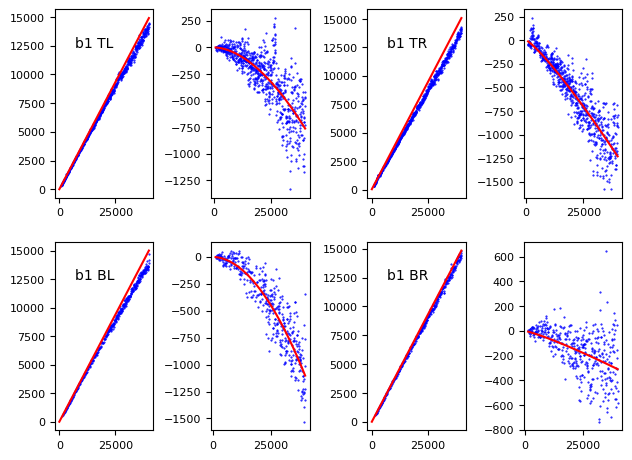

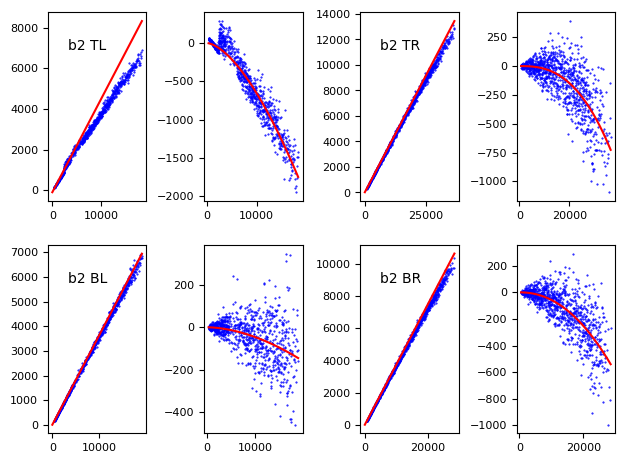

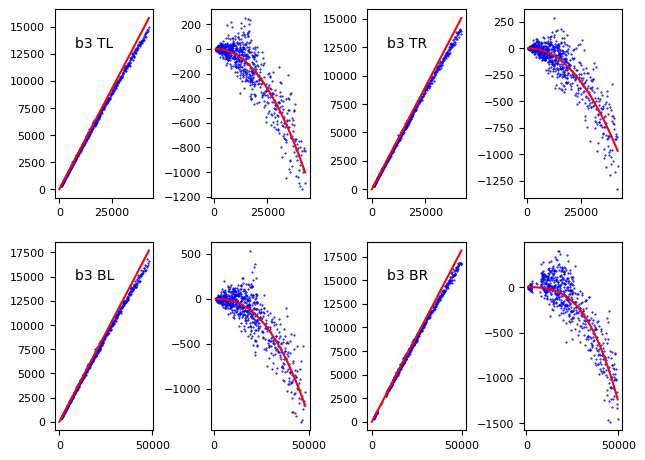

In [11]:
print('''
# Non-linear GAIN fit to PTC data, ND, 9/6/2023
#    var(ADU) = a1*ADU + a2*ADU^a3
#    GAIN(ADU) = 1 / (a1 + a2*a3 * ADU^(a3-1))
# C: Channel and Spectrograph
# Q: Quadrant
# a_i: coefficients as above
#C Q   a1     a2        a3''')

ptc_channel('b', '1')
ptc_channel('b', '2')
ptc_channel('b', '3')

r1 BL  0.372   -1.574E-06 0.981
r1 BR  0.404   -0.0001195 0.620
r1 TL  0.371   -3.874E-07 1.109
r1 TR  0.371   -4.96E-06 0.880
r2 BL  0.356   -6.712E-15 2.959
r2 BR  0.368   -2.601E-09 1.634
r2 TL  0.370   -1.972E-05 0.587
r2 TR  0.377   -5.112E-07 1.103
r3 BL  0.364   -2.136E-06 0.932
r3 BR  0.369   -1.826E-07 1.161
r3 TL  0.365   -2.904E-08 1.355
r3 TR  0.383   -2.716E-05 0.719


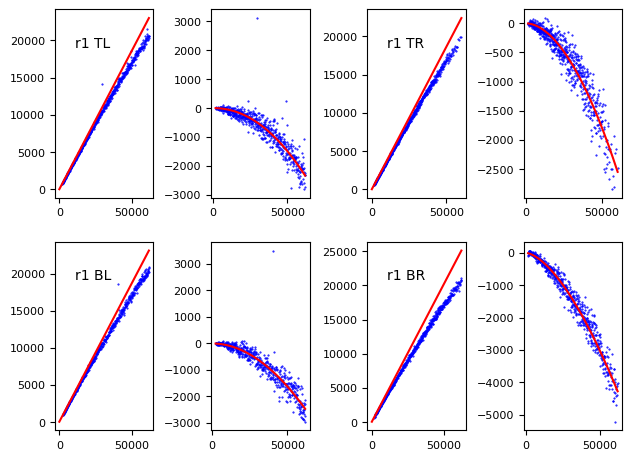

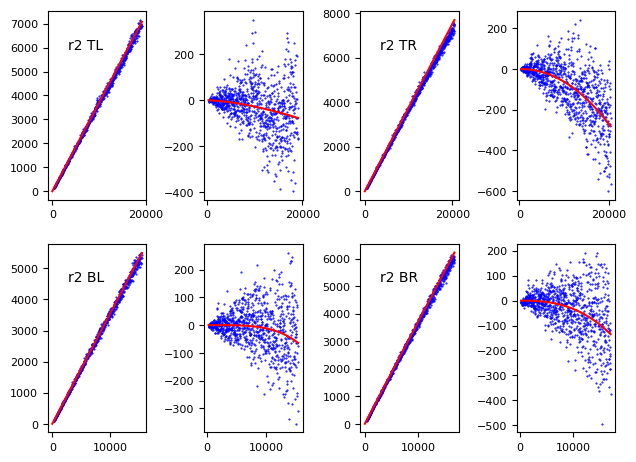

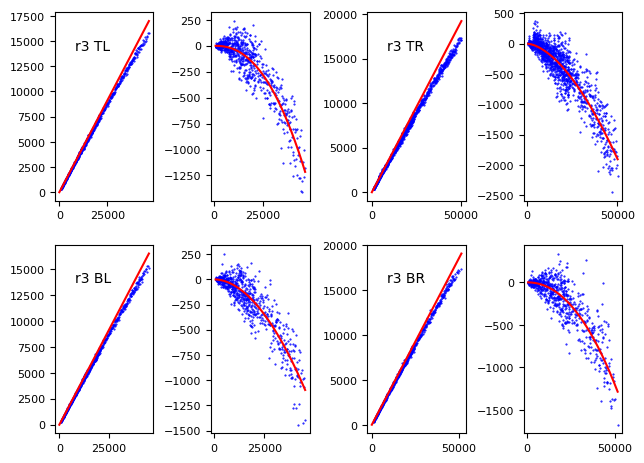

In [12]:
ptc_channel('r', '1')
ptc_channel('r', '2')
ptc_channel('r', '3')


z1 BL  0.367   -1.313E-12 2.323
z1 BR  0.368   -6.629E-10 1.798
z1 TL  0.362   -6.606E-07 1.111
z1 TR  0.360   -3.252E-09 1.647
z2 BL  0.369   -2.024E-06 1.015
z2 BR  0.359   -3.385E-07 1.191
z2 TL  0.360   -1.146E-06 1.062
z2 TR  0.350   -1.865E-07 1.240
z3 BL  0.357   -3.652E-07 1.170
z3 BR  0.360   -5.556E-07 1.136
z3 TL  0.392   -0.0004387 0.536
z3 TR  0.354   -3.31E-07 1.184


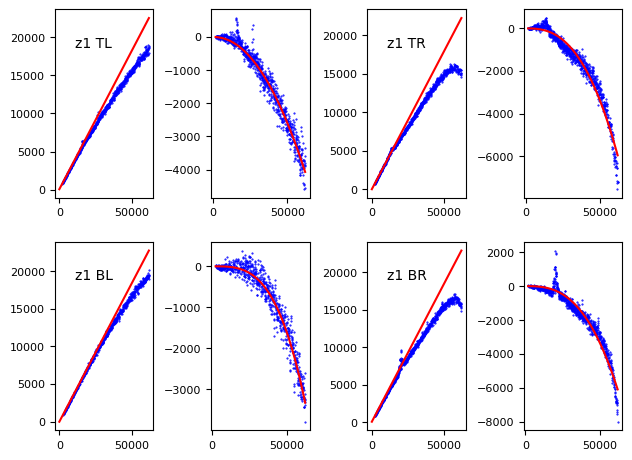

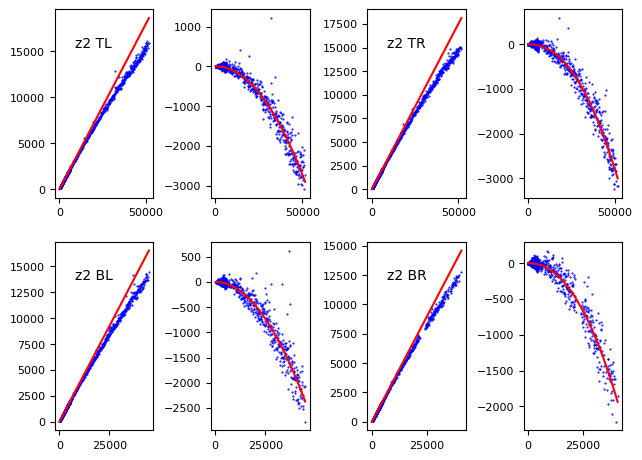

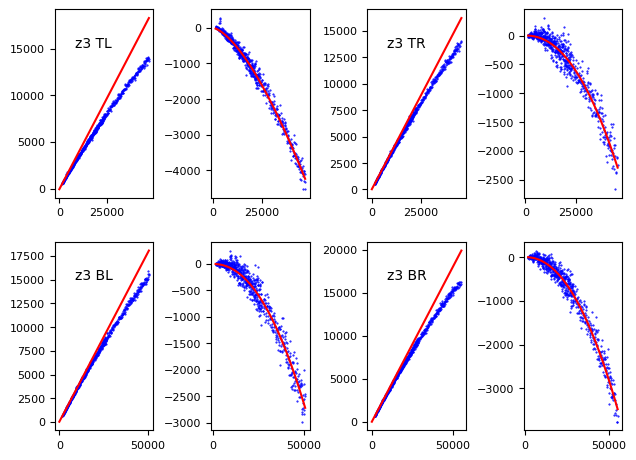

In [13]:
ptc_channel('z', '1')
ptc_channel('z', '2')
ptc_channel('z', '3')